In [1]:
import os
import cv2
from SegTracker import SegTracker
from model_args import aot_args,sam_args
from PIL import Image
from aot_tracker import _palette
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import gc
def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')
    return np.array(save_mask)
def draw_mask(img, mask, alpha=0.5, id_countour=False):
    img_mask = np.zeros_like(img)
    img_mask = img
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids!=0]

        for id in obj_ids:
            # Overlay color on  binary mask
            if id <= 255:
                color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)
            binary_mask = (mask == id)

            # Compose image
            img_mask[binary_mask] = foreground[binary_mask]

            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 0
    else:
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 0
        
    return img_mask.astype(img.dtype)

/home/dlr-rmc/hjkim/segment_ws/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dlr-rmc/hjkim/segment_ws/venv/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Set parameters for input and output

In [2]:
video_name = 'toro'
io_args = {
    'input_image': f'./assets/{video_name}.png',
    'output_mask_dir': f'./assets/{video_name}_masks', # save pred masks
    'output_video': f'./assets/{video_name}_seg.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
    'output_gif': f'./assets/{video_name}_seg.gif', # mask visualization
}

### Tuning SAM on the First Frame for Good Initialization

final text_encoder_type: bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized
processed frame 0, obj_num 1
time cost:  4.891739845275879


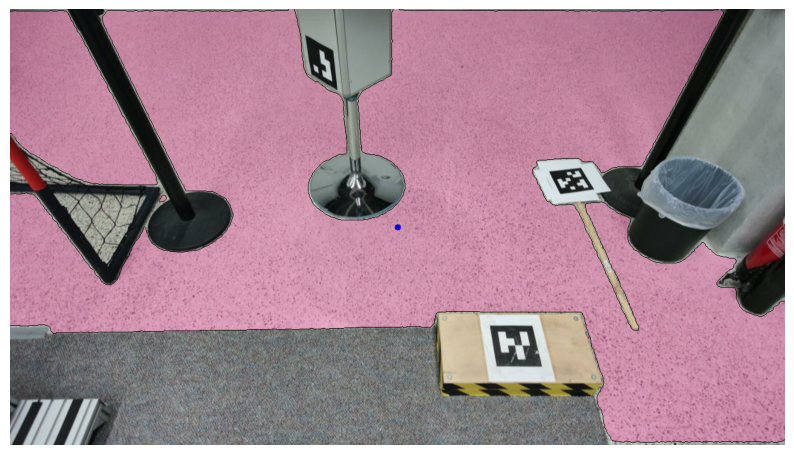

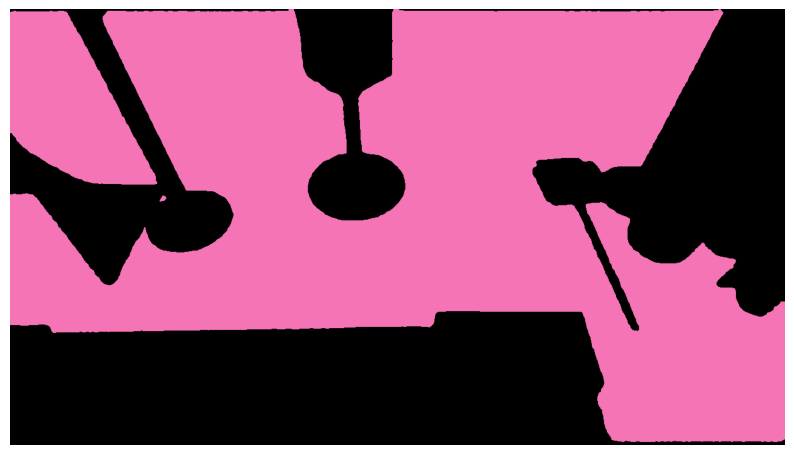

In [4]:
import time
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args['generator_args'] = {
    'points_per_side': 30,
    'pred_iou_thresh': 0.8,
    'stability_score_thresh': 0.9,
    'crop_n_layers': 1,
    'crop_n_points_downscale_factor': 1,
    'min_mask_region_area': 1500,
}
    
segtracker_args = {
    'sam_gap': 10, # the interval to run sam to segment new objects
    'min_area': 200, # minimal mask area to add a new mask as a new object
    'max_obj_num': 1, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
}
points = np.array([[640, 360]])
prompt = {
    "point_coords" : points,
    "point_modes" : np.array([1]),
    "multimask" : False,
}

frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()

start_time = time.time()
with torch.cuda.amp.autocast():
    frame = cv2.imread(io_args['input_image'])
    # pred_mask = segtracker.seg(frame)
    # pred_mask, _ = segtracker.seg_acc_click(
    #                                         origin_frame=frame,
    #                                         coords=prompt["points_coord"],
    #                                         modes=prompt["points_mode"],
    #                                         multimask=prompt["multimask"])
    

    pred_mask = segtracker.sam.segment_with_click(
                                            origin_frame=frame,
                                            coords=prompt["point_coords"],
                                            modes=prompt["point_modes"],
                                            multimask=prompt["multimask"])
    torch.cuda.empty_cache()
    obj_ids = np.unique(pred_mask)
    obj_ids = obj_ids[obj_ids!=0]
    print("processed frame {}, obj_num {}".format(frame_idx,len(obj_ids)),end='\n')
    init_res = draw_mask(frame,pred_mask,id_countour=False)
    init_res = cv2.circle(init_res, tuple(points[0]), 5, (0, 0, 255), -1)
    finish_time = time.time()
    print("time cost: ",finish_time-start_time)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(init_res)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(colorize_mask(pred_mask))
    plt.show()

    del segtracker
    torch.cuda.empty_cache()
    gc.collect()

processed frame 0, obj_num 1
time cost:  0.36461830139160156


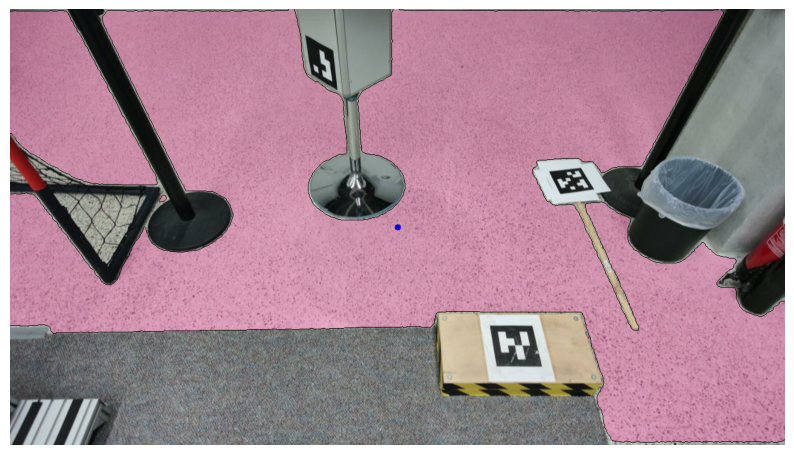

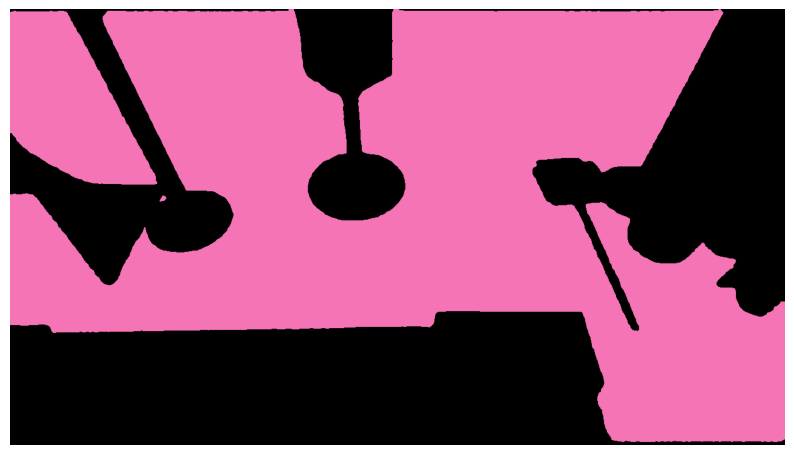

In [10]:
# segtracker = SegTracker(segtracker_args,sam_args,aot_args)

points = np.array([[640, 360]])
prompt = {
    "point_coords" : points,
    "point_modes" : np.array([1]),
    "multimask" : False,
}

segtracker.restart_tracker()

start_time = time.time()
with torch.cuda.amp.autocast():
    frame = cv2.imread(io_args['input_image'])
    # pred_mask = segtracker.seg(frame)
    # pred_mask, _ = segtracker.seg_acc_click(
    #                                         origin_frame=frame,
    #                                         coords=prompt["points_coord"],
    #                                         modes=prompt["points_mode"],
    #                                         multimask=prompt["multimask"])
    

    pred_mask = segtracker.sam.segment_with_click(
                                            origin_frame=frame,
                                            coords=prompt["point_coords"],
                                            modes=prompt["point_modes"],
                                            multimask=prompt["multimask"])
    torch.cuda.empty_cache()
    obj_ids = np.unique(pred_mask)
    obj_ids = obj_ids[obj_ids!=0]
    print("processed frame {}, obj_num {}".format(frame_idx,len(obj_ids)),end='\n')
    init_res = draw_mask(frame,pred_mask,id_countour=False)
    init_res = cv2.circle(init_res, tuple(points[0]), 5, (0, 0, 255), -1)
    finish_time = time.time()
    print("time cost: ",finish_time-start_time)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(init_res)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(colorize_mask(pred_mask))
    plt.show()

    del SegTracker
    torch.cuda.empty_cache()
    gc.collect()

In [29]:
image1 = cv2.imread('./assets/toro1.jpg')
image2 = cv2.imread('./assets/toro2.jpg')
image3 = cv2.imread('./assets/frame.jpg')
image_old = cv2.imread('./assets/toro_old.png')
imaeg_old = cv2.cvtColor(image_old, cv2.COLOR_RGB2BGR)

def plot(image, mask, points=None):
    image_copy = image.copy()
    if points is not None:
        for i in range(len(points)):
            image_copy = cv2.circle(image_copy, tuple(points[i]), 15, (0, 0, 255), -1)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(draw_mask(image_copy, mask, id_countour=False))
    plt.show()

In [39]:
import time
frame_idx = 0
sam_args['generator_args'] = {
        'points_per_side': 32,
        'pred_iou_thresh': 0.8,
        'stability_score_thresh': 0.9,
        'crop_n_layers': 1,
        'crop_n_points_downscale_factor': 2,
        'min_mask_region_area': 20000,
    }

segtracker_args = {
    'sam_gap': 9999,        # the interval to run sam to segment new objects (only auto mode)
    'min_area': 8000,   # minimal mask area to add a new mask as a new object
    'max_obj_num': 255,     # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
}

segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()


final text_encoder_type: bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized


time cost:  0.06603860855102539


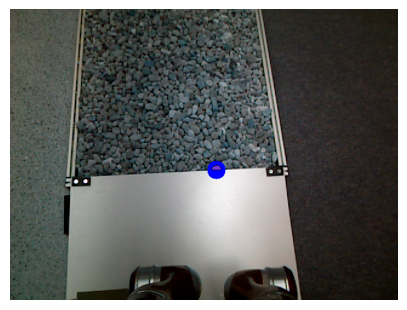

In [53]:
points = np.array([[340, 265]])
prompt = {
    "point_coords" : points,
    "point_modes" : np.array([1]),
    "multimask" : False,
}


start_time = time.time()
pred_mask = segtracker.sam.segment_with_click(
                                        image_old,
                                        prompt["point_coords"],
                                        prompt["point_modes"],
                                        # segtracker_args['min_area'],
                                        multimask=prompt["multimask"])
end_time = time.time()
print("time cost: ",end_time-start_time)
plot(image_old, pred_mask, points)

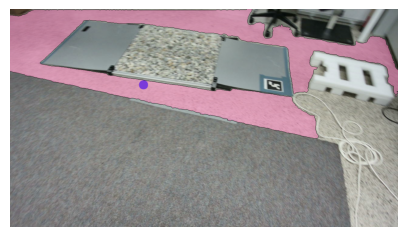

In [60]:
single_mask = np.zeros((pred_mask.shape[0] + 2, pred_mask.shape[1] + 2), dtype=np.uint8)
pred_mask_copy = pred_mask.copy()
cv2.floodFill(pred_mask_copy, single_mask, points[0], 1, (0,), (0,), flags=cv2.FLOODFILL_MASK_ONLY)
single_mask = single_mask[1:-1, 1:-1]
plot(image3, single_mask, points)

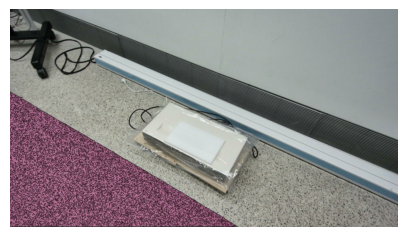

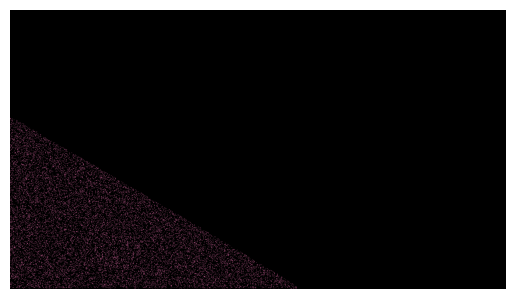

In [152]:
# Define the percentage of pixels to set to zero
loss_percentage = 0.9  # 10% of the pixels will be set to zero

# Get the total number of pixels
total_pixels = pred_mask.size

# Calculate the number of pixels to set to zero
num_loss_pixels = int(total_pixels * loss_percentage)

# Get the indices of the pixels to set to zero
loss_indices = np.random.choice(total_pixels, num_loss_pixels, replace=False)

# Flatten the mask, set the selected pixels to zero, and reshape it back
flat_mask = pred_mask.flatten()
flat_mask[loss_indices] = 0
pred_mask_loss = flat_mask.reshape(pred_mask.shape)

# Plot the mask with information loss
plot(image1, pred_mask_loss)
plt.imshow(colorize_mask(pred_mask_loss))
plt.axis('off')
plt.show()

In [153]:
segtracker.add_reference(image1, pred_mask_loss)
torch.cuda.empty_cache()
gc.collect()

12091

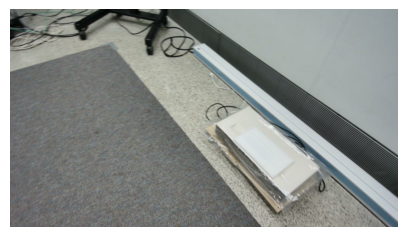

In [154]:
track_mask = segtracker.track(image2, update_memory=True)
plot(image2, track_mask)


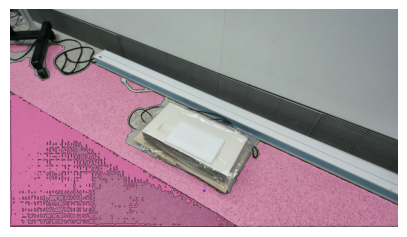

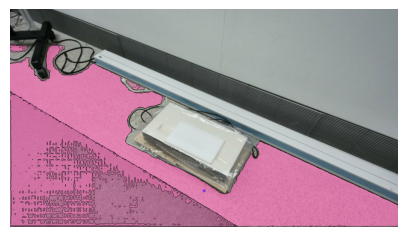

In [124]:
points = np.array([[640, 600]])
prompt = {
    "point_coords" : points,
    "point_modes" : np.array([1]),
}

multimask = False
pred_masks2, scores2, logits2 = segtracker.sam.interactive_predict(prompt, 'point', multimask)
pred_mask2_mid = pred_masks2[np.argmax(scores2)].astype(np.uint8)
logit2 = logits2[np.argmax(scores2), :, :]
prompts = {
    "point_coords" : points,
    "point_modes" : np.array([1]),
    'mask_prompt' : logit2[None, :, :]
}

pred_masks2_pm, scores2, logits2 = segtracker.sam.interactive_predict(prompts, 'point_mask', multimask)
pred_mask2 = pred_masks2_pm[np.argmax(scores2)].astype(np.uint8)

# pred_mask2 = segtracker.sam.segment_with_click(
#                                         origin_frame=image1,
#                                         coords=prompt["point_coords"],
#                                         modes=prompt["point_modes"],
#                                         multimask=prompt["multimask"])
torch.cuda.empty_cache()
gc.collect()
plot(image1, pred_mask2_mid, points)
plot(image1, pred_mask2, points)

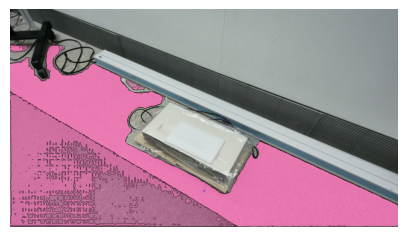

In [125]:
pred_mask2 = np.where(pred_mask2 != 0, pred_mask2 + 1, pred_mask2)
new_obj_mask = segtracker.find_new_objs(pred_mask, pred_mask2)
plot(image1, new_obj_mask)

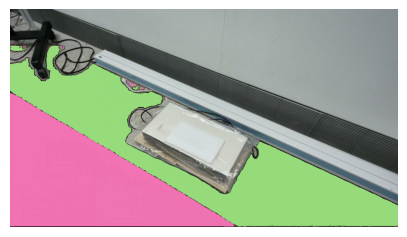

10625

In [136]:
new_obj_mask = np.where(new_obj_mask != 0, new_obj_mask + 1, new_obj_mask)
pred_mask2_ref = pred_mask + new_obj_mask
plot(image1, pred_mask2_ref)
segtracker.add_reference(image1, pred_mask2_ref)
torch.cuda.empty_cache()
gc.collect()

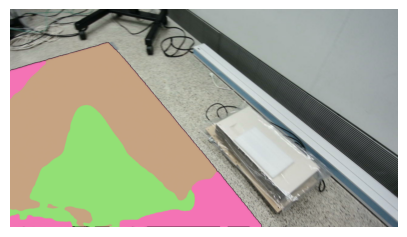

In [137]:
track_mask = segtracker.track(image2, update_memory=True)
plot(image2, track_mask)


In [113]:
output_height, output_width = image2.shape[0], image2.shape[1]
sample = {'current_img': image2}
sample = segtracker.tracker.transform(sample)
image = sample[0]['current_img'].unsqueeze(0).float().cuda(segtracker.tracker.gpu_id)
segtracker.tracker.engine.match_propogate_one_frame(image)
pred_logit = self.engine.decode_current_logits((output_height, output_width))

# pred_prob = torch.softmax(pred_logit, dim=1)
pred_label = torch.argmax(pred_logit, dim=1,
                            keepdim=True).float()

NameError: name 'self' is not defined

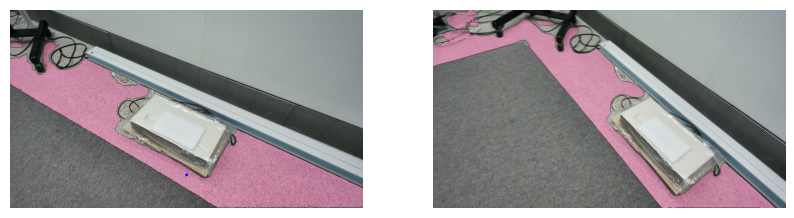

In [10]:
pred_mask2 = segtracker.track(image2, update_memory=True)
torch.cuda.empty_cache()
gc.collect()

init_res1 = draw_mask(image1,pred_mask,id_countour=False)
init_res1 = cv2.circle(init_res1, tuple(points[0]), 5, (0, 0, 255), -1)
init_res2 = draw_mask(image2,pred_mask2,id_countour=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(init_res1)
ax1.axis('off')
ax2.imshow(init_res2)
ax2.axis('off')
plt.show()

In [110]:
del segtracker
torch.cuda.empty_cache()
gc.collect()


NameError: name 'segtracker' is not defined

### Generate Results for the Whole Video

In [112]:
video_name = 'toro'
io_args = {
    'input_video_dir': f'/home/dlr-rmc/Downloads/TORO_dataset',
    'output_mask_dir': f'./assets/{video_name}_masks', # save pred masks
    'output_video': f'./assets/{video_name}_seg.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
    'output_gif': f'./assets/{video_name}_seg.gif', # mask visualization
}

/home/dlr-rmc/Downloads/TORO_dataset/seq6


['toro.1.0.png',
 'toro.2.0.png',
 'toro.3.0.png',
 'toro.4.0.png',
 'toro.5.0.png',
 'toro.6.0.png',
 'toro.7.0.png',
 'toro.8.0.png',
 'toro.9.0.png',
 'toro.10.0.png',
 'toro.11.0.png',
 'toro.12.0.png',
 'toro.13.0.png',
 'toro.14.0.png',
 'toro.15.0.png',
 'toro.16.0.png',
 'toro.17.0.png',
 'toro.18.0.png',
 'toro.19.0.png',
 'toro.20.0.png',
 'toro.21.0.png',
 'toro.22.0.png',
 'toro.23.0.png',
 'toro.24.0.png',
 'toro.25.0.png',
 'toro.26.0.png',
 'toro.27.0.png',
 'toro.28.0.png',
 'toro.29.0.png',
 'toro.30.0.png',
 'toro.31.0.png',
 'toro.32.0.png',
 'toro.33.0.png',
 'toro.34.0.png',
 'toro.35.0.png',
 'toro.36.0.png',
 'toro.37.0.png',
 'toro.38.0.png',
 'toro.39.0.png',
 'toro.40.0.png',
 'toro.41.0.png',
 'toro.42.0.png',
 'toro.43.0.png',
 'toro.44.0.png',
 'toro.45.0.png',
 'toro.46.0.png',
 'toro.47.0.png',
 'toro.48.0.png',
 'toro.49.0.png',
 'toro.50.0.png',
 'toro.51.0.png',
 'toro.52.0.png',
 'toro.53.0.png',
 'toro.54.0.png',
 'toro.55.0.png',
 'toro.56.0.png',
 

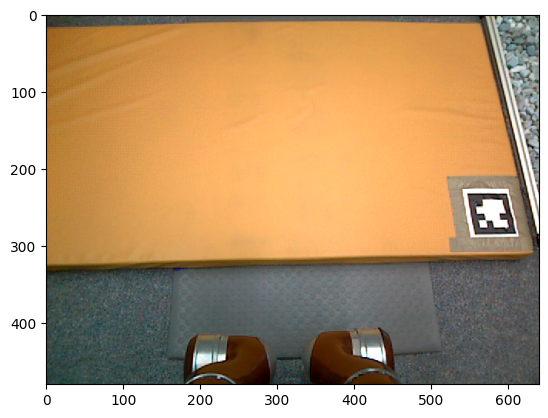

In [183]:
dataset_dir = io_args['input_video_dir']
dirs = os.listdir(dataset_dir)
dirs.sort()
seq = os.path.join(dataset_dir, dirs[7])
print(seq)
seq_files = os.listdir(seq)
frame = cv2.imread(os.path.join(seq, seq_files[1]))
plt.imshow(frame)
# for file in seq_files:
#     number = file.split('.')[1]
#     if len(number) == 1:
#         number = '00' + number
#     elif len(number) == 2:
#         number = '0' + number
    
seq_files_sort = sorted(seq_files, key=lambda x: int(x.split('.')[1]))
seq_files_sort

In [180]:
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    'sam_gap': 5, # the interval to run sam to segment new objects
    'min_area': 200, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
}

points = np.array([[frame.shape[1]//2, frame.shape[0]//2]])
prompt = {
    "point_coords" : points,
    "point_modes" : np.array([1]),
    "multimask" : False,
}

# source video to segment

fps = 25
dataset_dir = io_args['input_video_dir']
frames = os.listdir(dataset_dir)
frames.sort()

# output masks
output_dir = io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pred_list = []
masked_pred_list = []

torch.cuda.empty_cache()
gc.collect()
sam_gap = segtracker_args['sam_gap']
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()
with torch.cuda.amp.autocast():
    for i in seq_files_sort[650:]:
        frame = cv2.imread(os.path.join(seq, i))
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        if frame_idx == 0:
            point_id = 0
        else:
            for i in range(-5,6):
                for j in range(-5,6):
                    point_id = pred_mask[points[0][1]-i, points[0][0]-j]
                    if point_id != 0:
                        break
                if point_id != 0:
                    break

        if point_id == 0:
            segtracker.restart_tracker()
            print("add reference")
            segtracker.sam.interactive_predictor.set_image(frame)
            pred_mask = segtracker.sam.segment_with_click(
                                        origin_frame=frame,
                                        coords=prompt["point_coords"],
                                        modes=prompt["point_modes"],
                                        multimask=prompt["multimask"])
            segtracker.add_reference(frame, pred_mask)
        else:
            print("track")
            pred_mask = segtracker.track(frame, update_memory=True)
        
        torch.cuda.empty_cache()
        gc.collect()

        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png')
        pred_list.append(pred_mask)
        
        
        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        frame_idx += 1
    print('\nfinished')

final text_encoder_type: bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized
add reference
trackssed frame 0, obj_num 1
trackssed frame 1, obj_num 1
trackssed frame 2, obj_num 1
trackssed frame 3, obj_num 1
trackssed frame 4, obj_num 1
trackssed frame 5, obj_num 1
trackssed frame 6, obj_num 1
trackssed frame 7, obj_num 1
trackssed frame 8, obj_num 1
trackssed frame 9, obj_num 1
trackssed frame 10, obj_num 1
trackssed frame 11, obj_num 1
trackssed frame 12, obj_num 1
trackssed frame 13, obj_num 1
trackssed frame 14, obj_num 1
trackssed frame 15, obj_num 1
trackssed frame 16, obj_num 1
trackssed frame 17, obj_num 1
trackssed frame 18, obj_num 1
trackssed frame 19, obj_num 1
trackssed frame 20, obj_num 1
trackssed frame 21, obj_num 1
trackssed frame 22, obj_num 1
trackssed frame 23, obj_num 1
trackssed frame 24, obj_num 1
tracksse

libpng error: Read Error


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### Save results for visualization

In [184]:
# draw pred mask on frame and save as a video
width = frame.shape[1]
height = frame.shape[0]
num_frames = len(pred_list)

fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(io_args['output_video'], fourcc, fps, (width, height))

frame_idx = 0
for i in seq_files_sort[650:]:
    if i == 'toro.3592.0.png':
        break
    frame = cv2.imread(os.path.join(seq, i))
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask = pred_list[frame_idx]
    masked_frame = draw_mask(frame,pred_mask)
    # masked_frame = masked_pred_list[frame_idx]
    masked_frame = cv2.cvtColor(masked_frame,cv2.COLOR_RGB2BGR)
    masked_frame = cv2.circle(masked_frame, tuple(points[0]), 5, (255, 0, 255), -1)
    out.write(masked_frame)
    frame_idx += 1
    print('frame {} writed'.format(frame_idx),end='\r')
out.release()
print("\n{} saved".format(io_args['output_video']))
print('\nfinished')

frame 2941 writed
./assets/toro_seg.mp4 saved

finished


In [181]:
print(os.path.join(seq,i))
a = cv2.imread(os.path.join(seq, 'toro.193.0.png'))

/home/dlr-rmc/Downloads/TORO_dataset/seq6/toro.3592.0.png


In [ ]:
# save colorized masks as a gif
imageio.mimsave(io_args['output_gif'],pred_list,fps=fps)
print("{} saved".format(io_args['output_gif']))

In [6]:
# manually release memory (after cuda out of memory)
del segtracker
torch.cuda.empty_cache()
gc.collect()

301